<a href="https://colab.research.google.com/github/misakiyanan/kaikaiba_BI_projects/blob/master/PM2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BI名企班，谢雅楠，20210103
github： 

## Thinking
1. 今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一  
时序数据库是用来存储和管理时间序列数据的数据库。  
时间序列数据成为增长最快的数据类型之一是由于它具有广泛的应用场景，如金融、经济、商业等。

## Action
PM2.5数据集  
https://archive.ics.uci.edu/ml/datasets/Beijing%20PM2.5%20Data  
预测未来北京PM2.5的值

In [53]:
## Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
## Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas_profiling as pf
%matplotlib inline

In [55]:
## Load data
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pm2.5/pollution.csv', index_col=0)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [56]:
values = dataset.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

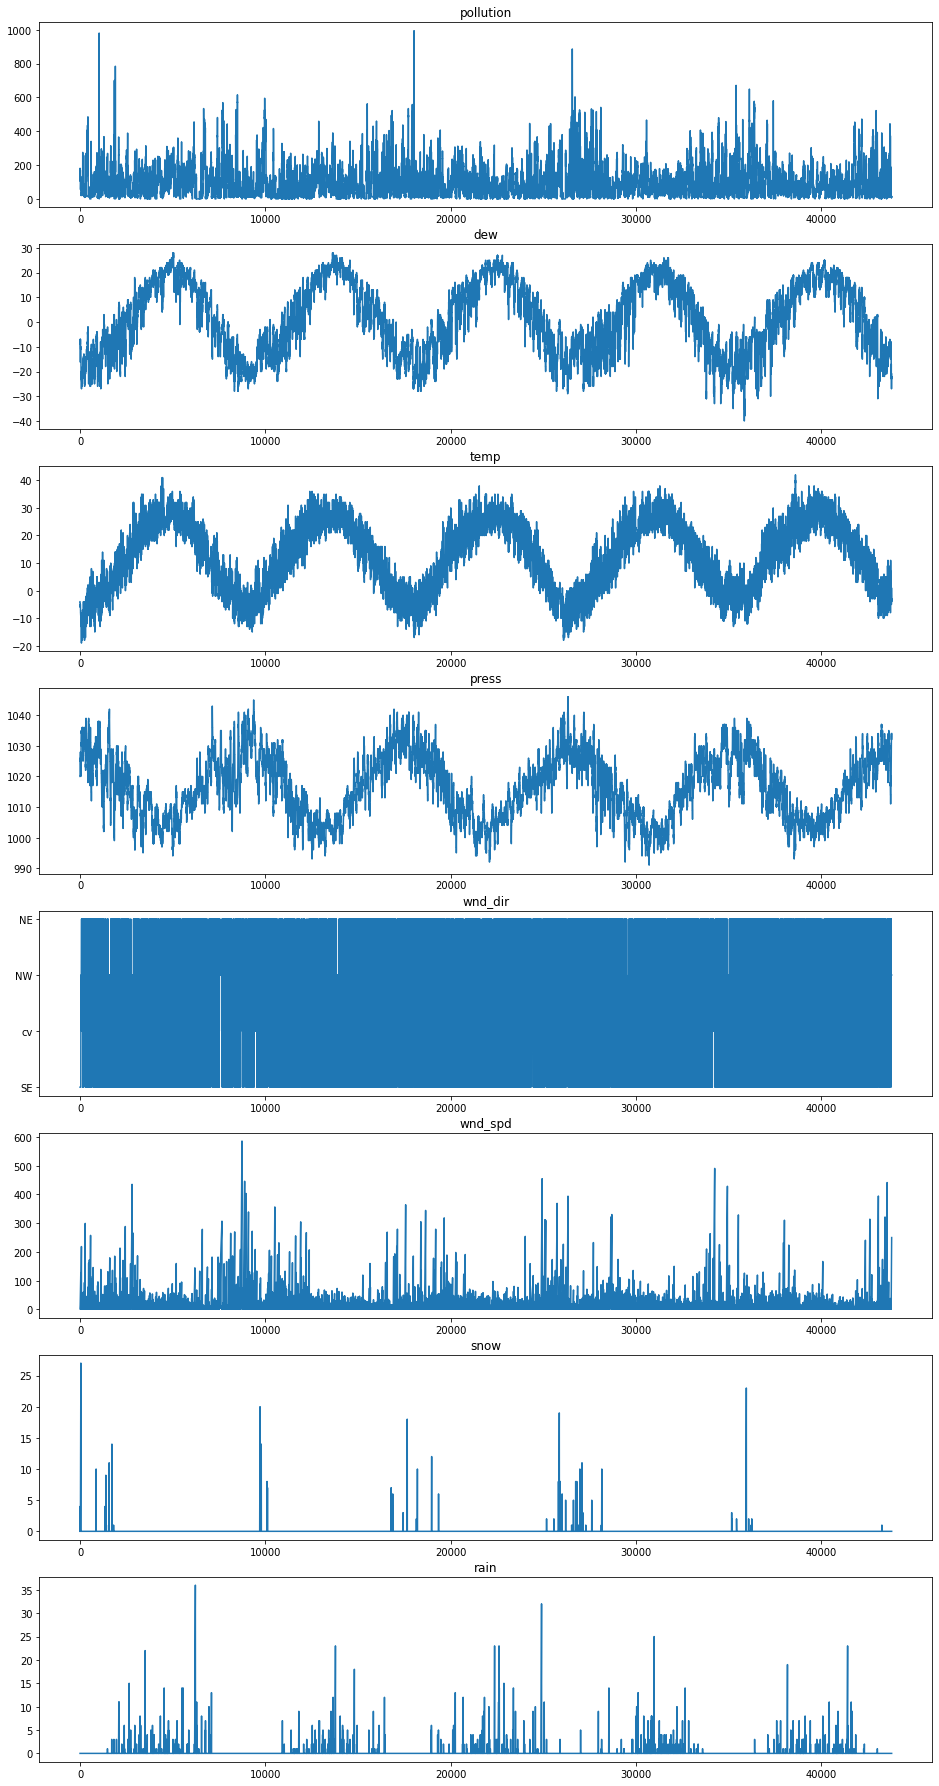

In [57]:
### EDA
i = 1
plt.figure(figsize=(16,32))
for group in range(8):
  plt.subplot(8,1,i)
  plt.plot(values[:, group])
  plt.title(dataset.columns[group])
  i += 1
plt.show()

In [58]:
dataset['wnd_dir'].value_counts()

SE    15290
NW    14130
cv     9384
NE     4996
Name: wnd_dir, dtype: int64

In [59]:
## 将分类特征wnd_dir进行标签编码
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# dataset.columns[5]
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [60]:
## 规范化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled.shape

(43800, 8)

In [61]:
# 将时间序列数据转换为适用于监督学习的数据
'''
data：观察序列
n_in：观察数据input(x)的步长，[1,len(data)], 默认为1
n_out：output(y)的步长,默认1
dropna：是否删除NaN

return 适用于监督学习的dataframe
'''
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # 去掉NaN行
  if dropnan:
    agg.dropna(inplace=True)
  return agg


In [62]:
# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
reframed.to_csv('reframed-1.csv')
# 去掉不需要预测的列，即var2(t)  var3(t)  var4(t)  var5(t)  var6(t)  var7(t)  var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv('reframed-2.csv')


In [63]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [64]:
## 切分训练集 测试集
values = reframed.values

n_train_hours = int(len(values) * 0.8)
train = values[: n_train_hours, :]
test = values[n_train_hours :, :]

train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]



In [66]:
## 转换为3D格式 （样本数 时间步 特征数）
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

## 设置网络模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

## 训练模型
result = model.fit(train_X, train_y, 
                   epochs=10, batch_size=64,
                   validation_data=(test_X, test_y), 
                   verbose=2, shuffle=False)



Epoch 1/10
548/548 - 3s - loss: 0.0036 - val_loss: 0.0070
Epoch 2/10
548/548 - 1s - loss: 8.5973e-04 - val_loss: 0.0023
Epoch 3/10
548/548 - 1s - loss: 8.0045e-04 - val_loss: 0.0016
Epoch 4/10
548/548 - 1s - loss: 7.9678e-04 - val_loss: 0.0014
Epoch 5/10
548/548 - 1s - loss: 7.9746e-04 - val_loss: 0.0013
Epoch 6/10
548/548 - 1s - loss: 7.9865e-04 - val_loss: 0.0012
Epoch 7/10
548/548 - 1s - loss: 7.9973e-04 - val_loss: 0.0011
Epoch 8/10
548/548 - 1s - loss: 8.0018e-04 - val_loss: 0.0011
Epoch 9/10
548/548 - 1s - loss: 8.0018e-04 - val_loss: 0.0011
Epoch 10/10
548/548 - 1s - loss: 7.9994e-04 - val_loss: 0.0011


In [76]:
## 预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)


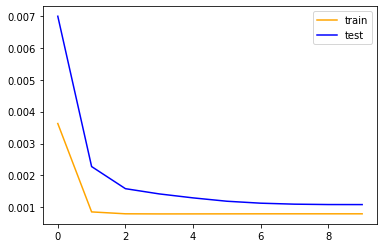

In [77]:
## plot loss
line1 = result.history['loss']
line2 = result.history['val_loss']

plt.plot(line1, label='train', c='orange')
plt.plot(line2, label='test', c='blue')
plt.legend(loc='best')
plt.show()

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


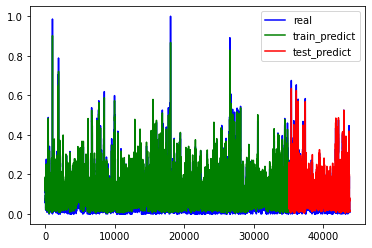

In [83]:
## plot
def plot_img(source_data_set, train_predict, test_predict):
  plt.plot(source_data_set[:,-1], label='real', c='b')
  plt.plot([x for x in train_predict], label='train_predict', c='g')
  plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test_predict', c='r')
  plt.legend(loc='best')
  plt.show()

plot_img(values, train_predict, test_predict)

In [84]:
## 模型评估
from sklearn.metrics import mean_squared_error

print('train MSE:', mean_squared_error(train_y, train_predict))
print('test MSE: ', mean_squared_error(test_y, test_predict))

train MSE: 0.0012442109
test MSE:  0.0010890141
